# *Capstone Project - Machine Learning Nanodegree Udacity*

## Desafio *Kaggle* - Porto Seguro

### Importando libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, f1_score, fbeta_score, roc_auc_score, auc
from sklearn.model_selection import StratifiedKFold

from time import time

### Leitura da base 

In [2]:
data = pd.read_csv('train/train.csv', na_values="-1")
#data_test = pd.read_csv('test/test.csv', na_values = "-1")
print(data.shape)

(595212, 59)


In [3]:
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


#### - variável target tem 3,64% de incidência na base.

In [4]:
count = pd.DataFrame(data['target'].value_counts())
percent = pd.DataFrame(data['target'].value_counts(normalize=True)*100)
table = pd.concat([count, percent], axis=1)
table.columns = ['# target', '% target']
table

,# target,% target
0,573518,96.355248
1,21694,3.644752


#### - separando em base treino e base teste

In [5]:
from sklearn.model_selection import train_test_split

#id_all = 
X_all = data.iloc[:,2:]
y_all = data.target

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.30 ,random_state = 791231)

print "Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1])
print "Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1])


Training set has 416648 samples and 57 features.
Testing set has 178564 samples and 57 features.


#### criando variável de quantidade de missing

In [6]:
temp = X_train.isnull().sum(axis=1)
X_train.loc[:,'n_miss']=temp
X_train.n_miss.value_counts(normalize=True)

table = pd.crosstab(X_train.n_miss, y_train)
sum_line = table.apply(lambda x:x.sum(),axis = 1)
p_target = table.iloc[:,1]/sum_line
p_total = sum_line / sum((sum(table.iloc[:,0]), sum(table.iloc[:,1])))
df = pd.concat([p_total, p_target ], axis=1)
df.columns = ['% cat', '% target']
print(df)

C:\Users\rhais\Anaconda2\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\rhais\Anaconda2\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


           % cat  % target
n_miss                    
0       0.209112  0.045073
1       0.261739  0.036212
2       0.429847  0.033692
3       0.094226  0.027408
4       0.004961  0.027092
6       0.000026  0.636364
7       0.000082  0.441176
8       0.000007  0.333333


#### - métrica gini normalizado será utilizada para avaliação do modelo

In [7]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)        

### Explorando os dados
#### Criando uma base com a quantidade de valores únicos de cada variável e percentual de *missings*:

Sobre os *missings*:
- temos 13 variáveis com alguma quantidade de missings;
- das variáveis categóricas: *ps_car_03_cat* possui 70% de missings e em seguida *ps_car_05_cat* com 45% de missings.
- das não categóricas *ps_reg_03* e *ps_car_14* com 18% e 7%, respectivamente.

Forma de tratamento:
- no caso das categóricas preenchimento com um outro número (99) representando a categoria missing (avaliaremos graficamente se faz sentido mantê-las separadas);
- no caso das numéricas aplicação da média e mediana.

In [8]:
#count unique values in columns and plot
len_array = []
for var in X_train.columns:
    current_len  = len(X_train[var].unique())
    len_array.append(current_len)

missing = pd.DataFrame(np.array(X_train.isnull().sum()), columns = ['missing'])
p_missing = missing / X_train.shape[0]

qtd = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(len_array), missing.missing, pd.DataFrame(p_missing)], axis = 1)
qtd.columns = ['var', '# unique values', '# missing','% missing']

qtd.iloc[:,0:2 ]

,var,# unique values
0,ps_ind_01,8
1,ps_ind_02_cat,5
2,ps_ind_03,12
3,ps_ind_04_cat,3
4,ps_ind_05_cat,8
5,ps_ind_06_bin,2
6,ps_ind_07_bin,2
7,ps_ind_08_bin,2
8,ps_ind_09_bin,2
9,ps_ind_10_bin,2


Sobre os *missings*:
- temos 13 variáveis com alguma quantidade de missings;
- das variáveis categóricas: *ps_car_03_cat* possui 70% de missings e em seguida *ps_car_05_cat* com 45% de missings.
- das não categóricas *ps_reg_03* e *ps_car_14* com 18% e 7%, respectivamente.

Forma de tratamento:
- no caso das categóricas preenchimento com um outro número (99) representando a categoria missing (avaliaremos graficamente se faz sentido mantê-las separadas);
- no caso das numéricas aplicação da média e mediana.

              var  # unique values  # missing  % missing
23  ps_car_03_cat                3     288187   0.691680
25  ps_car_05_cat                3     187199   0.449298
20      ps_reg_03             4963      75543   0.181311
35      ps_car_14              831      29776   0.071466
27  ps_car_07_cat                3       8128   0.019508
4   ps_ind_05_cat                8       4122   0.009893
29  ps_car_09_cat                6        400   0.000960
1   ps_ind_02_cat                5        139   0.000334
21  ps_car_01_cat               13         63   0.000151
3   ps_ind_04_cat                3         52   0.000125
32      ps_car_11                5          4   0.000010
22  ps_car_02_cat                3          2   0.000005
33      ps_car_12              174          1   0.000002
47     ps_calc_11               20          0   0.000000
40     ps_calc_04                6          0   0.000000


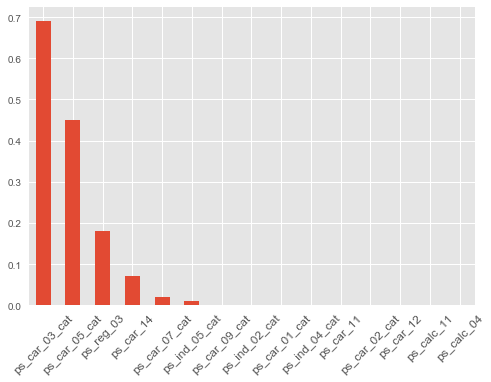

In [9]:
qtd = qtd.sort_values(by = '% missing', ascending = False)
print(qtd.iloc[0:15,:])

fig = plt.figure()
plt.style.use('ggplot')
ax1 = fig.add_subplot(111)
qtd.iloc[0:15,3].plot(kind = 'bar',ax=ax1)
ax1.set_xticklabels(qtd.iloc[0:15,0], rotation='45', fontsize=12)

plt.show()

#### Utilizando a orientação, realizando separação das variáveis binárias, das categóricas e das demais para respectivos tratamentos de *missings* e outras análises gráficas.


In [10]:
x_cols = np.array(X_train.columns)
names_bin = filter(lambda x: x.endswith('_bin'), x_cols)
names_cat = filter(lambda x: x.endswith('_cat'), x_cols)
names_others = filter(lambda x: not x in names_cat + names_bin, x_cols)

print(names_cat) 
print('\n')
print(names_bin)
print('\n')
print(names_others)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']


['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']


['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'n_miss']


In [11]:
len(names_cat)

14

Ajustando todas categóricas ou binárias para 99.

In [12]:
for var in names_cat:
    X_train.loc[:, var] = X_train.loc[:,var].fillna(999)
for var in names_bin:
    X_train.loc[:, var] = X_train.loc[:,var].fillna(999)

No caso da ps_reg_03 ajustado missing para a mediana

In [13]:
med_ps_reg03 = X_train['ps_reg_03'].median()

X_train['ps_reg_03_MED'] = X_train['ps_reg_03'].fillna(med_ps_reg03)


C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


As demais variáveis numéricas que apareceram na base serão substituídas pela respectiva mediana da coluna.

In [14]:
train_median =  X_train.apply(lambda x: x.median(), axis = 0)
for i in range(len(X_train.columns)):
    X_train.iloc[:, i] = X_train.iloc[:, i].fillna(train_median[i])

### Observações gerais a respeito dos gráficos abaixo:
Com os gráficos abaixo observamos que os missings tem uma incidência alta da variável target em muitas variáveis, o que é uma boa decisão mantê-los separados e não misturá-los com outras categorias.


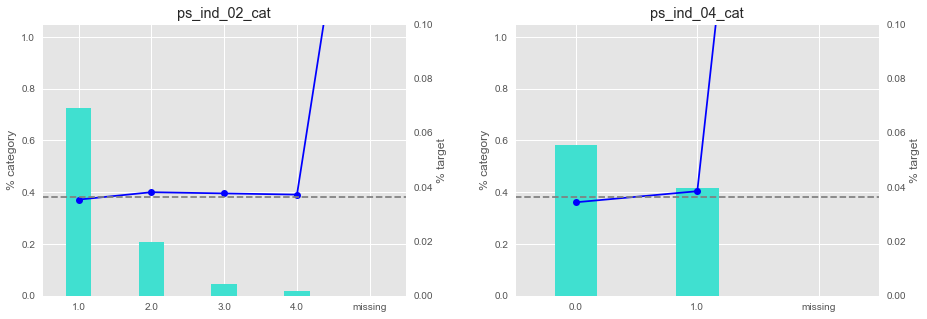

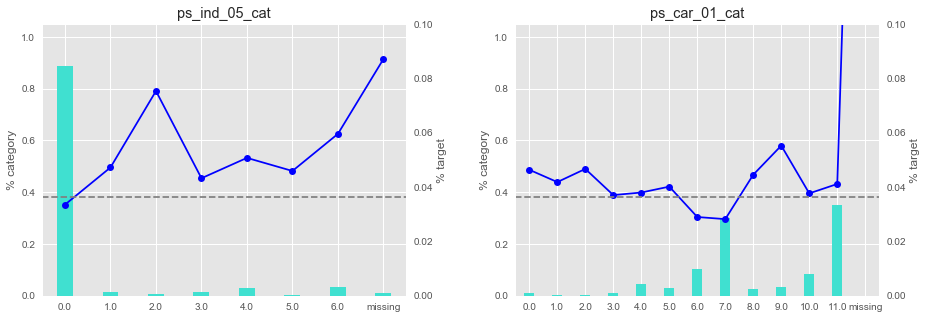

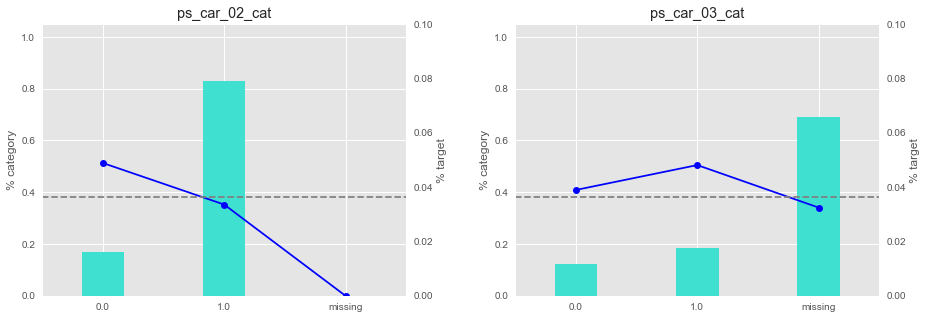

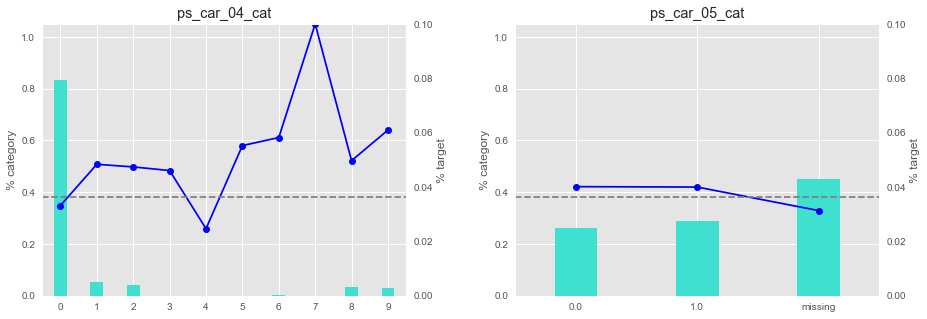

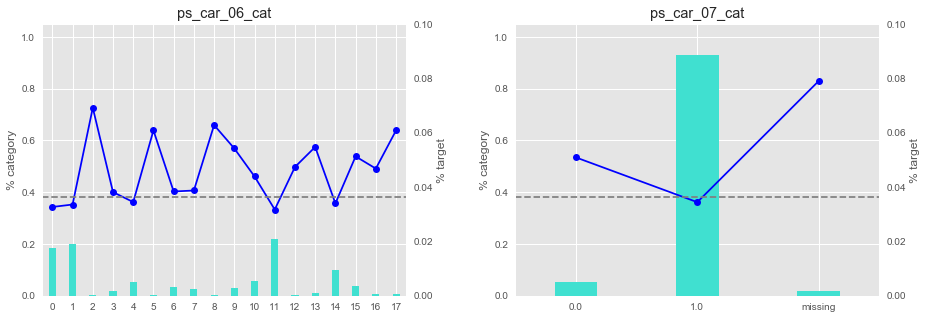

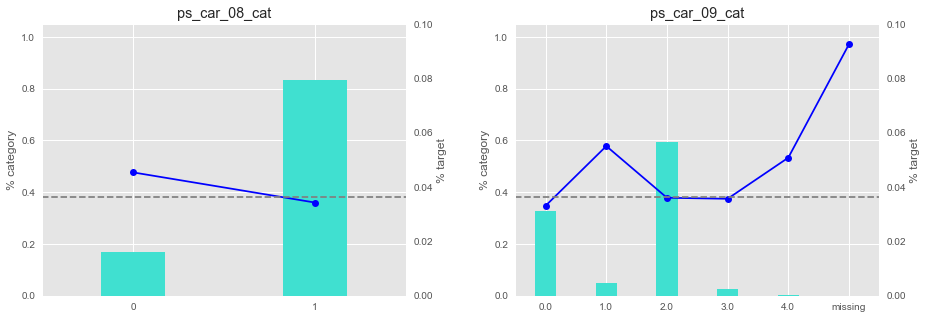

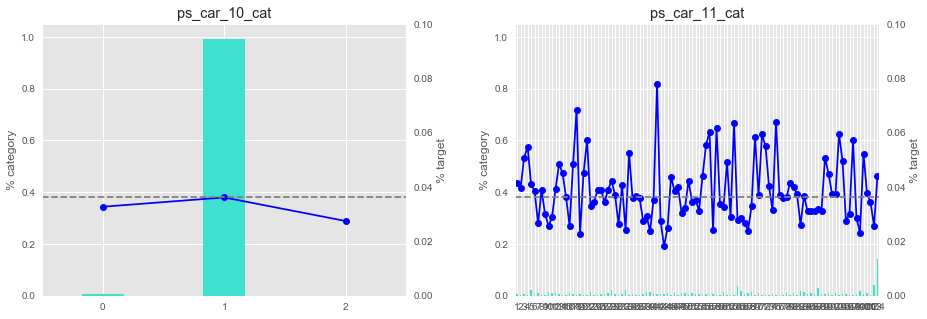

In [22]:
def addMiss(element):
    if element == 999:
        return 'missing'
    else:
        return element
i=1
for var in names_cat:
    table = pd.crosstab(X_train[var], y_train)
    sum_line = table.apply(lambda x:x.sum(),axis = 1)
    p_target = table.iloc[:,1]/sum_line
    p_total = sum_line / sum((sum(table.iloc[:,0]), sum(table.iloc[:,1])))
    df = pd.concat([p_total, p_target ], axis=1)
    df.columns = ['% cat', '% target']
    df.index = map(addMiss,  df.index)
    
    df['index2'] = df.index
    df['index2'] = df.index2.astype(str)
    
    #print(df)
    df.set_index('index2', inplace=True)
    if i % 2 != 0:
        fig = plt.figure(figsize = (15,5))
        j = 1
    else:
        j = 2
    
    ax1 = fig.add_subplot(1,2,j)
    df.iloc[:,0].plot(kind = 'bar', width = 0.35, color = 'turquoise', ax=ax1, title = var)
    ax1.set_xticklabels(np.array(df.index), rotation= '0')
    ax2 = ax1.twinx()
    df['% target'].plot(color = 'blue', ax = ax2, marker = 'o')
    
    spacing = 0.5
    ax1.set_ylim(0,1.05)
    ax2.set_xlim(-spacing, len(df['% cat']) - spacing)
    ax2.set_ylim(0,0.10)
    ax2.grid(False)
    plt.axhline(y=0.036477, color='gray', linestyle='--')
    ax1.set_xlabel('')
    ax1.set_ylabel('% category')
    ax2.set_ylabel('% target')
    ax1.yaxis.label.set_size(12)
    #ax1.legend (loc=0)
    #ax2.legend(bbox_to_anchor=(0.8, 1.5),fontsize=12)
    #ax1.legend(bbox_to_anchor=(0.9, 1.4),fontsize=12)
    
    ax2.yaxis.label.set_size(12)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    if i % 2 == 0:
        plt.show()
    i=i+1
    
    

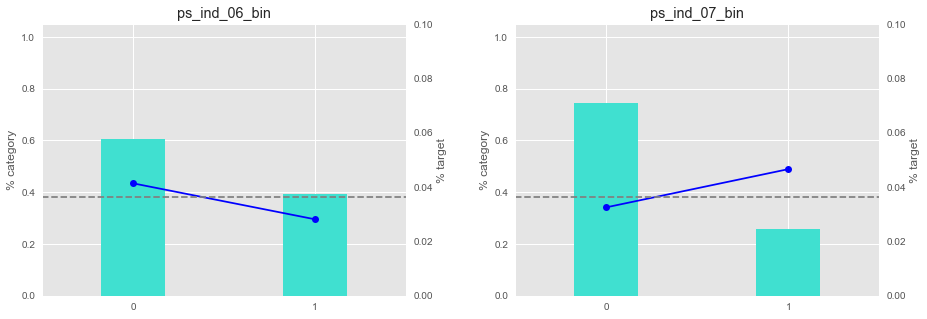

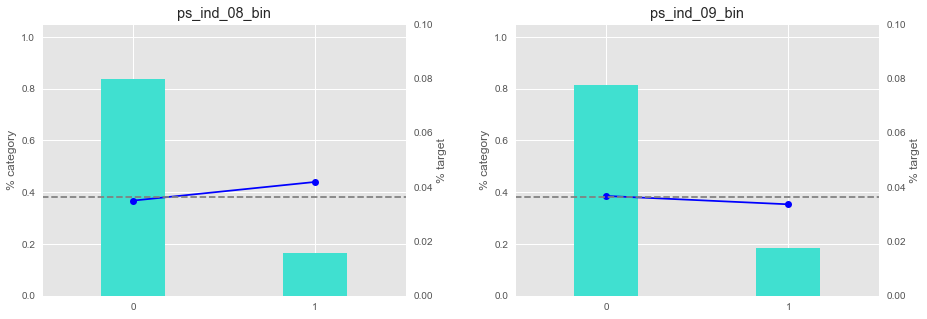

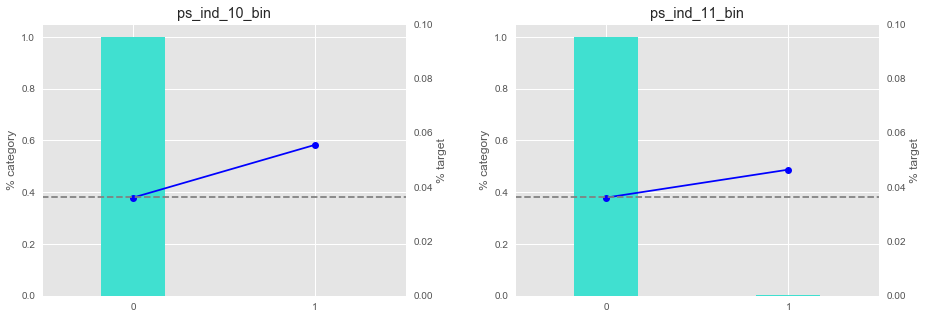

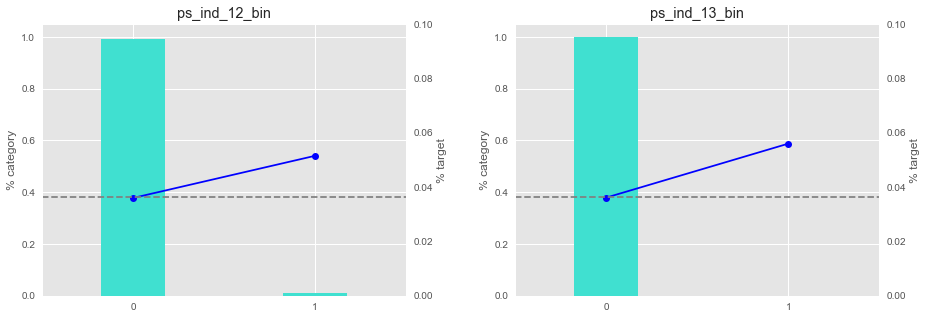

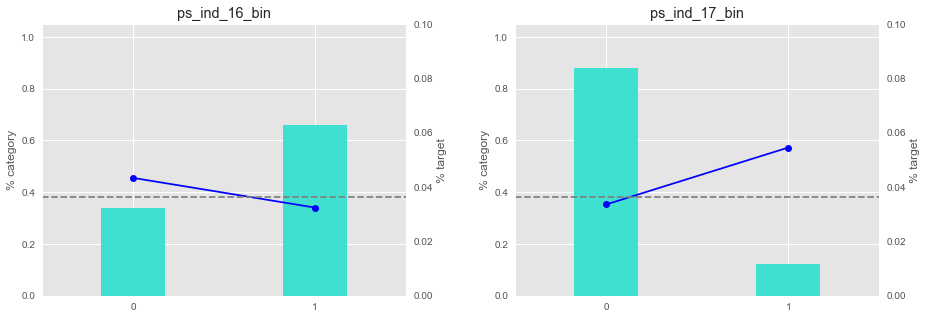

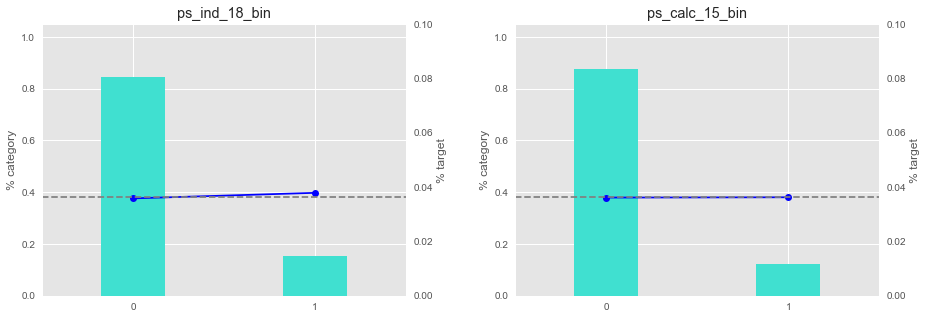

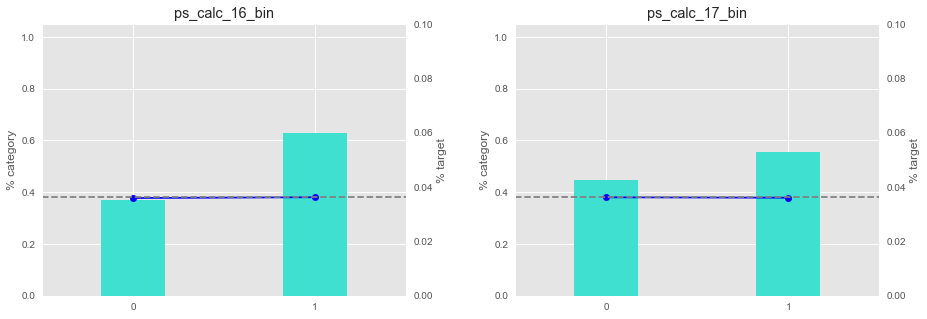

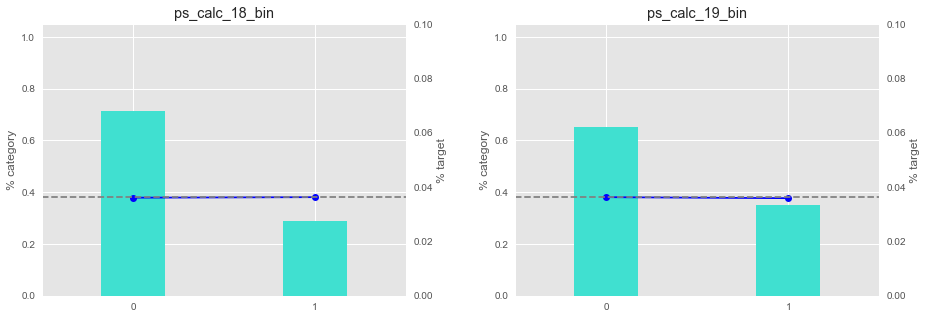

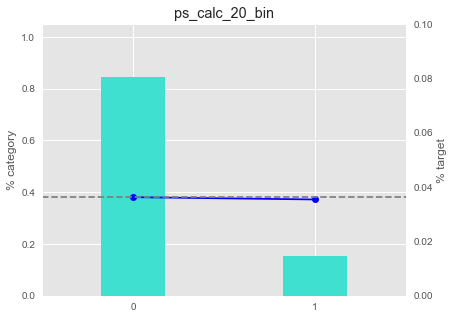

In [23]:
plt.style.use('ggplot')
i=1
for var in names_bin:
    table = pd.crosstab(X_train[var], y_train)
    sum_line = table.apply(lambda x:x.sum(),axis = 1)
    p_target = table.iloc[:,1]/sum_line
    p_total = sum_line / sum((sum(table.iloc[:,0]), sum(table.iloc[:,1])))
    df = pd.concat([p_total, p_target ], axis=1)
    df.columns = ['% cat', '% target']
    df.index = map(addMiss,  df.index)
    
    df['index2'] = df.index
    df['index2'] = df.index2.astype(str)
    
    #print(df)
    df.set_index('index2', inplace=True)
    if i % 2 != 0:
        fig = plt.figure(figsize = (15,5))
        j = 1
    else:
        j = 2
    
    ax1 = fig.add_subplot(1,2,j)
    df.iloc[:,0].plot(kind = 'bar', width = 0.35, color = 'turquoise', ax=ax1, title = var)
    ax1.set_xticklabels(np.array(df.index), rotation= '0')
    ax2 = ax1.twinx()
    df['% target'].plot(color = 'blue', ax = ax2, marker = 'o')
    
    spacing = 0.5
    ax1.set_ylim(0,1.05)
    ax2.set_xlim(-spacing, len(df['% cat']) - spacing)
    ax2.set_ylim(0,0.10)
    ax2.grid(False)
    plt.axhline(y=0.036477, color='gray', linestyle='--')
    ax1.set_xlabel('')
    ax1.set_ylabel('% category')
    ax2.set_ylabel('% target')
    ax1.yaxis.label.set_size(12)
    ax2.yaxis.label.set_size(12)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    if i % 2 == 0:
        plt.show()
    i=i+1

In [24]:
def groups (n_groups, var, y_resp):
    ser = pd.qcut(var, n_groups, retbins = False)
    train = pd.DataFrame(pd.crosstab(ser, y_resp))
    #print(ser, train)
    train.columns = ['N_0', 'N_1']
    train['total'] = train.N_0 + train.N_1
    train['P_1'] = np.round(train['N_1'] / train['total'],2)
    train['P_total'] = np.round((train['total'] / sum(train.total) ), 2)
   # train['index2'] = train.index.categories.astype(str)
    
    return (train)

def plots_groups_num (table, figsize_1 = 14, figsize_2 = 6, bar_width = 0.91, fontsize_inside= 13, fontsize_axis = 13):
    
    fig = plt.figure(figsize=(figsize_1, figsize_2))
    ax = fig.add_subplot(1, 1, 1)
    #plot
    A = table.P_1
    B = 1- table.P_1
    bar_l = range(len(table.index))
    ax1 = ax.bar(bar_l, A, width=bar_width,label="A", color="#e87109" )
    ax2 = ax.bar(bar_l, B, bottom = A,width=bar_width,label="B", color="#3842f7")

    # visual elements
    ax.set_xlabel("Grupos", fontsize=18)
    ax.legend(['% target = 1','% target = 0'],bbox_to_anchor=(1, 0.9),fontsize=fontsize_axis)
    plt.yticks(fontsize=fontsize_axis)
    plt.xticks(fontsize=fontsize_axis)
    plt.title(table.index.name,fontsize=18)
    ax.set_ylim(0,1.13)
    

    #print(table)
    #plotting texts inside bars
    i = 0
    for r1, r2 in zip(ax1, ax2):
        #aux = table.P_total
        h1 = np.round(r1.get_height(),decimals=2)
        h2 = np.round(r2.get_height(),decimals=2)
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., h1, ha="center", va="center", color="white", fontsize=fontsize_inside, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 /2., h2, ha="center", va="center", color="white", fontsize=fontsize_inside, fontweight="bold")
        plt.text(r1.get_x() + r1.get_width() / 2, h1+h2 +0.05, '{:.0%}'.format(table.P_total.iloc[i],2), ha="center", va="center", color="gray", fontsize=13)
        #print(table.P_total[i])
        i = i + 1

plt.show()

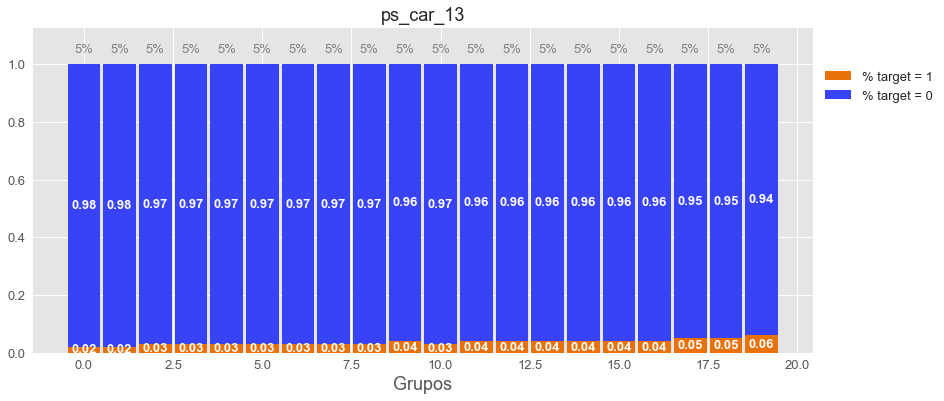

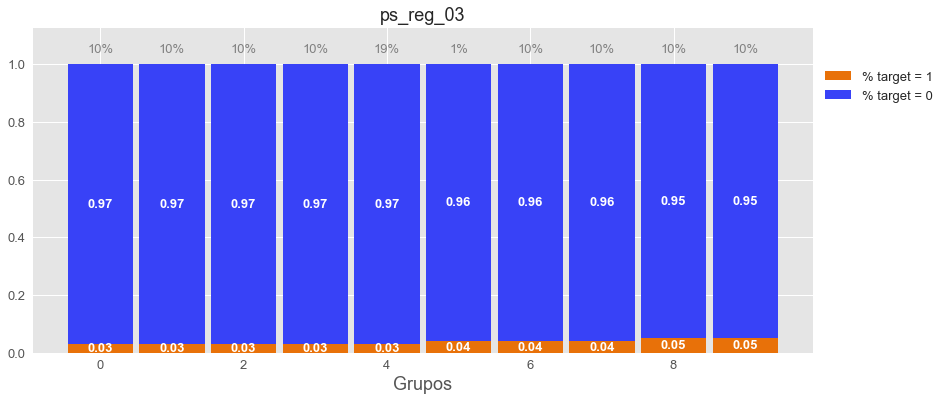

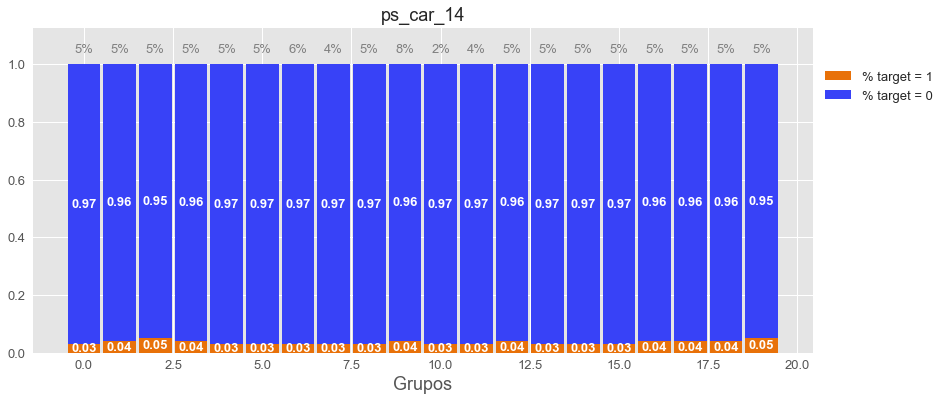

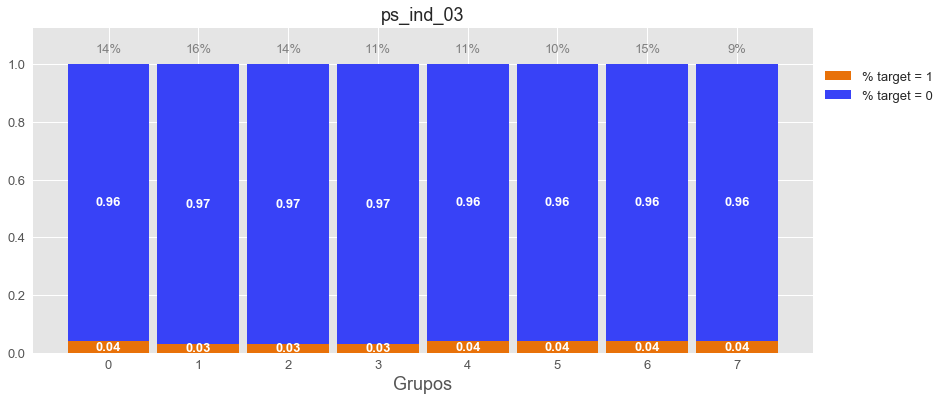

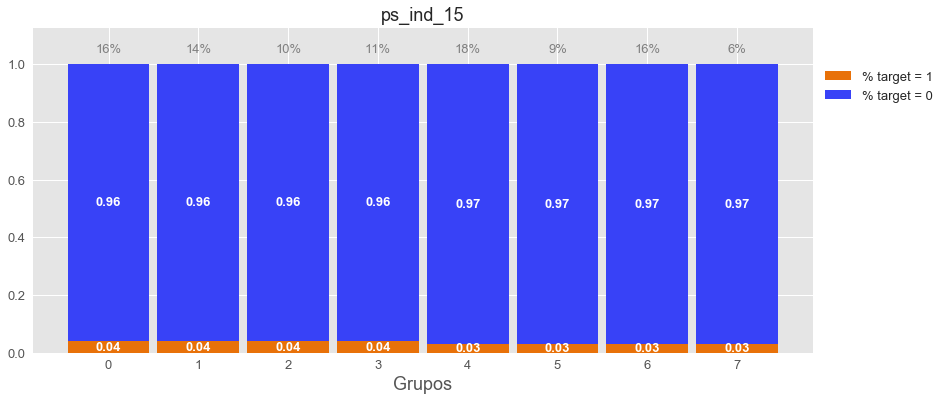

In [25]:
list_vars = ['ps_car_13', 'ps_reg_03', 'ps_car_14', 'ps_ind_03', 'ps_ind_15' ]
list_n_fx = [20, 10, 20, 8, 8]

for index_num, var in enumerate(list_vars):
    table = groups(list_n_fx[index_num], X_train[var] , y_train)
    plots_groups_num (table)
    
           

#### agrupamento

In [26]:
def transf_car11cat (elemento):
    if elemento in [41,18,75,63,58]:
        return 1
    elif elemento in [56, 93,71,69, 21,97,55,72,4,33,100,89, 3, 94]:
        return 2
    elif elemento in [61, 13, 17, 20, 14, 90,104]:
        return 3
    elif elemento in [54, 45, 50, 28, 1, 79, 5, 31, 73, 80, 47, 2, 12]:
        return 4
    elif elemento in [12, 27, 8, 25, 24, 6, 46, 101, 91, 92, 81, 70, 29]:
        return 5
    elif elemento in [76, 83, 35, 15, 78, 36, 77, 34, 52, 40, 23]:
        return 6
    elif elemento in [51, 102, 26, 59, 22, 68, 60, 49, 87, 74, 53, 88, 85, 86, 84, 48, 96, 9]:
        return 7
    elif elemento in [38, 11, 62, 65, 98, 64, 37, 42, 95]:
        return 8
    elif elemento in [66, 7, 30, 82, 103, 16, 10, 44]:
        return 9
    elif elemento in [32, 57, 67, 39, 99, 19, 43]:
        return 10
    else:
        return 10

X_train['ps_car_11_cat_v2'] = map(transf_car11cat , X_train['ps_car_11_cat'])
#print(X_train['ps_car_11_cat_v2'].value_counts())
#print(X_train['ps_car_11_cat'].value_counts())




C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


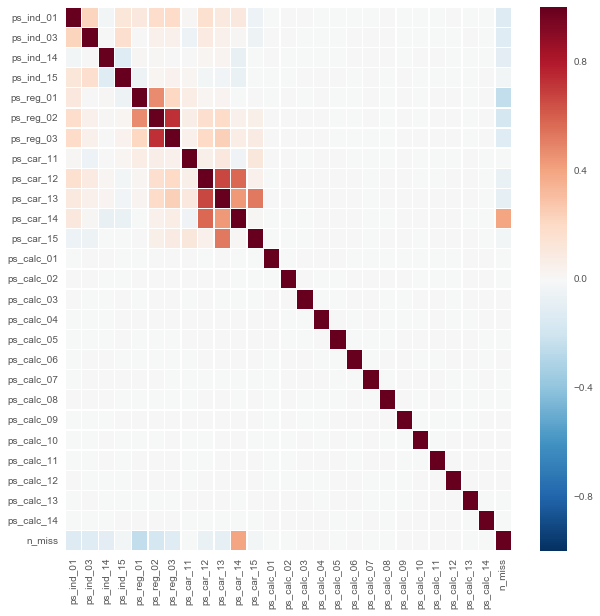

In [27]:
def corr_heatmap (data, figsize_1= 10, figsize_2 = 10, see_numbers= False):
    fig, plot = plt.subplots(figsize=(figsize_1, figsize_2)) 
    plot = sns.heatmap(pd.DataFrame.corr(data), linewidths=0.3, annot = see_numbers)
    return plot

corr_heatmap(X_train[names_others])

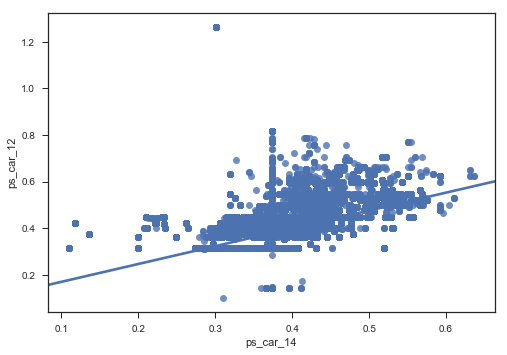

In [36]:
#sns.regplot(x= 'ps_car_13', y= 'ps_car_12' ,data = X_train)
sns.regplot(x= 'ps_car_14', y= 'ps_car_12' ,data = X_train)
#sns.regplot(x= 'ps_car_14', y= 'ps_car_13' ,data = X_train)

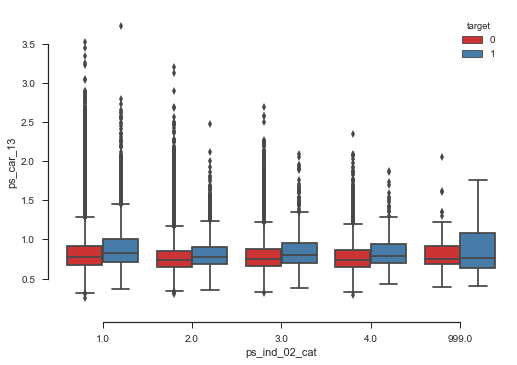

In [30]:
x='ps_ind_02_cat'
y='ps_car_13'

base_boxplot = pd.concat([ X_train[[x,y]], y_train ], axis = 1)

sns.set(style="ticks")
sns.boxplot(x= x,
            y=y,
            hue = 'target',
            data = base_boxplot,
            palette = 'Set1'
           )
sns.despine(sns.despine(offset=10, trim=True))

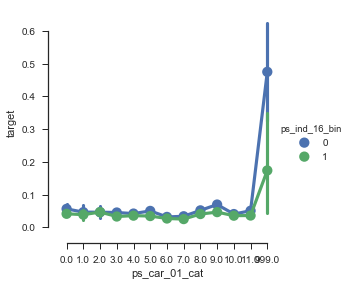

In [34]:

x='ps_car_01_cat'
y='target'
z='ps_ind_16_bin'

base_boxplot = pd.concat([ X_train[[x,z]], y_train ], axis = 1)

sns.set(style="ticks")
sns.factorplot(x= x,
            y=y,
            hue = z,
            data = base_boxplot
      #      palette = 'Set1'
           )
sns.despine(sns.despine(offset=10, trim=True))
#sns.factorplot(x="time", y="pulse", hue="kind", data=exercise)